In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import cv2 

2024-03-01 10:07:12.369793: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 10:07:12.546033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 10:07:12.546124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 10:07:12.572027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 10:07:12.636068: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 10:07:12.637560: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Load Model

In [2]:
interpretter = tf.lite.Interpreter(model_path = 'models/archive/singlepose-lightning.tflite')
interpretter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Draw Keypoints Fucntion

In [3]:
# Dictionary that maps from joint names to keypoint indices
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c', 
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y', 
    (11, 13): 'm', 
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores, height, width, keypoint_threshold=0.11):
    """Return high confidence keypoints and edges for visualization.
    Args: 
        keypoints_with_scores: A numpy array with shape [1, 1, 17, 3]
        representing the keypoint coordinates and scores returned from the MoveNet model.
        Input:
        height: of the image
        width: of the image
        keypoint_threshold: minimum confidence score

        Return:
        coordinates of all keypoints
        coordinates of all skeleton edges
        colors of edges
        """
    keypoints_all = []
    keypoint_edges_all = []
    edge_colors = []
    num_instances, _, _, _ = keypoints_with_scores.shape
    for idx in range(num_instances):
        kpts_x = keypoints_with_scores[0, idx, :, 1]
        kpts_y = keypoints_with_scores[0, idx, :, 0]
        kpts_scores = keypoints_with_scores[0, idx, :, 2]
        kpts_absolute_xy = np.stack([width *np.array(kpts_x), height*np.array(kpts_y)], axis = -1)
        kpts_above_thresh_absolute = kpts_absolute_xy[kpts_scores > keypoint_threshold, :]
        keypoints_all.append(kpts_above_thresh_absolute)

        for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
            if(kpts_scores[edge_pair[0]] > keypoint_threshold and 
               kpts_scores[edge_pair[1]] > keypoint_threshold):
                x_start = kpts_absolute_xy[edge_pair[0], 0]
                y_start = kpts_absolute_xy[edge_pair[0], 1]
                x_end = kpts_absolute_xy[edge_pair[1], 0]
                y_end = kpts_absolute_xy[edge_pair[1], 1]

                line_seg = np.array([[x_start, y_start], [x_end, y_end]])
                keypoint_edges_all.append(line_seg)
                edge_colors.append(color)
    
    if keypoints_all:
        keypoints_xy = np.concatenate(keypoints_all, axis = 0)
    else:
        keypoints_xy = np.zeros((0, 17, 2)) # there is no detected person
    
    if keypoint_edges_all:
        edges_xy = np.stack(keypoint_edges_all, axis = 0)
    else:
        edges_xy = np.zeros((0, 2, 2))
    return keypoints_xy, edges_xy, edge_colors
    

In [4]:
def draw_prediction_on_image(
        image, keypoints_with_scores, crop_region = None, close_figure=False,
        output_image_height = None
):
    """Draws the keypoint predictions on image.
    
    Args:
        image: A  numpy array 
        kepoints_with_scores
        crop_region: A dictionary that defines the coordinates of the bounding box of 
        the crop region in normalized coordinates
        output_image_height: An integer indicating the height of the output image
        (The image aspect ratio will be the same as the input image)
    Return :
        an array with shape [out_height, out_width, channel] representing the image"""
    height, width, channel = image.shape 
    aspect_ratio = float(width) / height 
    fig, ax = plt.subplots(figsize = (12 * aspect_ratio, 12))
    
    # To remove the huge white borders
    fig.tight_layout(pad = 0)
    ax.margins(0)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.axis('off')

    im = ax.imshow(image)
    line_segments = LineCollection([], linewidths = (4), linestyle = 'solid')
    ax.add_collection(line_segments)
    # Turn off tick labels
    scat = ax.scatter([], [], s = 60, color = '#FF1493', zorder=3)

    (keypoints_locs, keypoint_edges, edge_colors) = _keypoints_and_edges_for_display(keypoints_with_scores, height, width)
    

    # line_segments.set_segments(keypoint_edges)
    # line_segments.set_color(edge_colors)
    if keypoint_edges.shape[0]:
        line_segments.set_segments(keypoint_edges)
        line_segments.set_color(edge_colors)
    if keypoints_locs.shape[0]:
        scat.set_offsets(keypoints_locs)

    if crop_region is not None:
        xmin = max(crop_region['x_min']*width, 0.0)
        ymin = max(crop_region['y_min']*height, 0.0)
        rec_width = min(crop_region['x_max'], 0.99)*width - xmin
        rec_height = min(crop_region['y_max'], 0.99)*height - ymin

        rect = patches.Rectangle(
            (xmin, ymin), rec_width, rec_height,
            linewidth = 1, edgecolor = 'b', facecolor = 'none'
        )
        ax.add_patch(rect)

    fig.canvas.draw()
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype = np.uint8)
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1]+(3,))
    plt.close(fig)

    if output_image_height is not None:
        output_image_width = int(output_image_height/height * width)
        image_from_plot = cv2.resize(
            image_from_plot, dsize = (output_image_width, output_image_height),
            interpolation=cv2.INTER_CUBIC
        )
    return image_from_plot 




### Read frames from video and run inference

In [5]:
input_details = interpretter.get_input_details()
input_details


[{'name': 'serving_default_input:0',
  'index': 0,
  'shape': array([  1, 192, 192,   3], dtype=int32),
  'shape_signature': array([  1, 192, 192,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [6]:
output_details = interpretter.get_output_details()
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3], dtype=int32),
  'shape_signature': array([ 1,  1, 17,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
cap = cv2.VideoCapture('./images/dancing.mp4')
while cap.isOpened():
    ret, frame = cap.read()

    

    # Reshape image
    image = frame.copy()
    input_image = tf.image.resize_with_pad(np.expand_dims(image, axis = 0), 192, 192)

    # Setup input and output
    input_details = interpretter.get_input_details()
    output_details = interpretter.get_output_details()

    # Run a inference
    # Allow you to convert the data type of a tensor to integer type
    input_image = tf.cast(input_image, dtype =tf.float32)
    
    interpretter.set_tensor(input_details[0]['index'], np.array(input_image))

    # Invoke inference
    interpretter.invoke()
    # Get the model prediction
    keypoints_with_scores = interpretter.get_tensor(output_details[0]['index'])

    # Visualize the predictions with image
    display_image = tf.expand_dims(image, axis = 0)
    display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype = tf.int32)

    output_overlay = draw_prediction_on_image(np.squeeze(np.array(display_image), axis = 0), keypoints_with_scores)

    cv2.imshow('Video', output_overlay)
    

    key = cv2.waitKey(10)
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

2024-03-01 10:07:36.460801: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-01 10:07:36.462156: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3866/748194110.py:57: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype = np.ui

In [10]:
keypoints_with_scores[0][0]

array([[0.6650711 , 0.6357719 , 0.64301646],
       [0.6114152 , 0.68908703, 0.599771  ],
       [0.61692435, 0.585565  , 0.64921   ],
       [0.63642955, 0.748701  , 0.52736723],
       [0.641284  , 0.52778864, 0.71994   ],
       [0.8647146 , 0.8660025 , 0.646226  ],
       [0.84665716, 0.42956752, 0.7245274 ],
       [0.9725789 , 0.95678735, 0.05826611],
       [0.9577793 , 0.36667046, 0.05615841],
       [0.86493504, 0.84905404, 0.01455918],
       [0.98906744, 0.50378215, 0.01615042],
       [1.0273771 , 0.8469283 , 0.01077394],
       [1.0175965 , 0.50361884, 0.0092147 ],
       [0.87868357, 0.91726995, 0.0212206 ],
       [0.8487339 , 0.39540598, 0.04594491],
       [1.0050163 , 0.7973596 , 0.00687517],
       [1.0252433 , 0.44603395, 0.00470849]], dtype=float32)

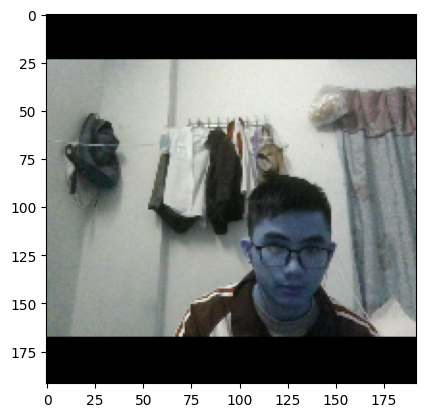

In [8]:
plt.imshow(np.squeeze(image))